
# Аналіз LTV користувачів мобільного застосунку з підписною моделлю

### *Виконавець:* **Наталія Ярема**

## Вступ

**ПРОДУКТ**  
Мобільний застосунок із підписною моделлю монетизації, який надає доступ до преміум-функцій через тижневу підписку.

**МЕТА АНАЛІЗУ**  
Оцінити фактичний Lifetime Value (LTV) користувачів на основі історичних даних та побудувати прогноз річного LTV (52 тижні) з використанням когортного підходу.

**ЗАВДАННЯ АНАЛІЗУ**  
1. Побудувати weekly cohort-based LTV та розрахувати кумулятивний фактичний LTV  
2. Побудувати предиктивну модель для прогнозування LTV на горизонті 52 тижнів  
3. Порівняти фактичну та прогнозну LTV криву  
4. Оцінити якість прогнозу та проаналізувати стабільність LTV тренду  
5. Надати бізнес-інсайти щодо монетизації та утримання користувачів  

**ОПИС ДАНИХ**  
Датасет містить події покупок користувачів та включає такі поля:  

- user_id — унікальний ідентифікатор користувача  
- event_timestamp — дата та час покупки  
- first_purchase_time — дата першої покупки  
- cohort_week — тиждень першої покупки (когорта)  
- lifetime_weeks — кількість тижнів від першої покупки  
- product_id — ідентифікатор продукту з інформацією про вартість підписки  

**ПЕРІОД АНАЛІЗУ**  
Березень 2023 — Жовтень 2023  

**ОБСЯГ ДАНИХ**  
- Подій: 6,086  
- Унікальних користувачів: 934  
- Продуктів: 1 (тижнева підписка $2.49)  

**КЛЮЧОВІ МЕТРИКИ**  
- LTV — сумарний дохід на одного користувача  
- Cohort LTV — LTV у розрізі когорт  
- Predicted LTV (52w) — прогнозований LTV на горизонті 52 тижнів  

**МЕТОДОЛОГІЯ**  
- Фактичний LTV розраховується як cumulative revenue per user у межах доступного історичного горизонту  
- Прогноз LTV будується на основі середньої когортної LTV кривої з використанням регресійної моделі  
- Порівняння фактичної та прогнозної кривої використовується для оцінки стабільності тренду  

**ОЧІКУВАНІ РЕЗУЛЬТАТИ**  
- Оцінка середнього річного LTV користувача  
- Виявлення динаміки монетизації по життєвому циклу користувача  
- Рекомендації щодо покращення retention та збільшення доходу  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from IPython.display import display, Markdown
from statsmodels.stats.proportion import proportion_confint, proportions_ztest

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 0) 

In [2]:
df = pd.read_csv(r'C:\Users\yarem\Desktop\TestTask\TestTask_Product_Analyst_Task2.csv', encoding='utf-8')

In [3]:
display(Markdown("# Первинний огляд даних"))

display(Markdown("## Розмір та структура"))
display(Markdown(f"**Rows:** {df.shape[0]:,} | **Columns:** {df.shape[1]}"))
display(Markdown("**Columns:** " + ", ".join(df.columns)))

df.head()

# Первинний огляд даних

## Розмір та структура

**Rows:** 6,086 | **Columns:** 6

**Columns:** user_id, event_timestamp, first_purchase_time, cohort_week, lifetime_weeks, product_id

,user_id,event_timestamp,first_purchase_time,cohort_week,lifetime_weeks,product_id
0,6f8592c0-fb4c-47dc-9344-424eb5d88a4b,2023-10-13 9:54:02,2023-10-13 9:54:02,2023-10-08,0,weekly.2.49
1,95287b91-85af-4174-9986-aeafb3853bb6,2023-10-14 4:45:14,2023-03-25 4:44:40,2023-03-19,29,weekly.2.49
2,95287b91-85af-4174-9986-aeafb3853bb6,2023-03-25 4:44:40,2023-03-25 4:44:40,2023-03-19,0,weekly.2.49
3,95287b91-85af-4174-9986-aeafb3853bb6,2023-04-01 4:44:16,2023-03-25 4:44:40,2023-03-19,1,weekly.2.49
4,95287b91-85af-4174-9986-aeafb3853bb6,2023-04-08 4:45:55,2023-03-25 4:44:40,2023-03-19,2,weekly.2.49


In [4]:
display(Markdown("## Типи даних (info)"))
df.info()

display(Markdown("## Пропущені значення по колонках"))
missing = pd.DataFrame({
    "missing_cnt": df.isna().sum(),
    "missing_pct": (df.isna().mean() * 100).round(2)
}).sort_values("missing_pct", ascending=False)

display(missing)

## Типи даних (info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6086 entries, 0 to 6085
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              6086 non-null   object
 1   event_timestamp      6086 non-null   object
 2   first_purchase_time  6086 non-null   object
 3   cohort_week          6086 non-null   object
 4   lifetime_weeks       6086 non-null   int64 
 5   product_id           6086 non-null   object
dtypes: int64(1), object(5)
memory usage: 285.4+ KB


## Пропущені значення по колонках

,missing_cnt,missing_pct
user_id,0,0.0
event_timestamp,0,0.0
first_purchase_time,0,0.0
cohort_week,0,0.0
lifetime_weeks,0,0.0
product_id,0,0.0


In [5]:
display(Markdown("## Описова статистика (numeric)"))
display(df.select_dtypes(include=np.number).describe().T)

display(Markdown("## Описова статистика (categorical)"))
display(df.select_dtypes(exclude=np.number).describe().T)

## Описова статистика (numeric)

,count,mean,std,min,25%,50%,75%,max
lifetime_weeks,6086.0,7.603188,7.263496,0.0,1.0,5.0,12.0,32.0


## Описова статистика (categorical)

,count,unique,top,freq
user_id,6086,934,95287b91-85af-4174-9986-aeafb3853bb6,32
event_timestamp,6086,6076,2023-05-11 15:02:48,2
first_purchase_time,6086,932,2023-03-06 12:02:11,32
cohort_week,6086,32,2023-03-05,639
product_id,6086,1,weekly.2.49,6086


In [6]:
display(Markdown("## Унікальні значення (ключові сутності)"))

unique_stats = pd.DataFrame({
    "Метрика": ["Унікальних користувачів", "Унікальних продуктів", "Унікальних когорт"],
    "Значення": [
        df["user_id"].nunique(),
        df["product_id"].nunique(),
        df["cohort_week"].nunique()
    ]
})
display(unique_stats)

## Унікальні значення (ключові сутності)

,Метрика,Значення
0,Унікальних користувачів,934
1,Унікальних продуктів,1
2,Унікальних когорт,32


In [7]:
display(Markdown("## Перевірка якості даних"))

checks = {}

# lifetime_weeks
lw = pd.to_numeric(df["lifetime_weeks"], errors="coerce")
checks["lifetime_weeks_nan_pct"] = float(lw.isna().mean())
checks["negative_lifetime_weeks_cnt"] = int((lw < 0).sum())
checks["max_lifetime_weeks"] = float(lw.max()) if lw.notna().any() else np.nan

# event_timestamp vs first_purchase_time
ev = pd.to_datetime(df["event_timestamp"], errors="coerce")
fp = pd.to_datetime(df["first_purchase_time"], errors="coerce")
checks["event_before_first_purchase_pct"] = float((ev < fp).mean())

display(pd.Series(checks, name="value"))

## Перевірка якості даних

lifetime_weeks_nan_pct              0.0
negative_lifetime_weeks_cnt         0.0
max_lifetime_weeks                 32.0
event_before_first_purchase_pct     0.0
Name: value, dtype: float64

In [8]:
display(Markdown("## Підсумки EDA"))

total_rows = df.shape[0]
total_users = df["user_id"].nunique()
total_products = df["product_id"].nunique()
total_cohorts = df["cohort_week"].nunique()
overall_missing_pct = float((df.isna().sum().sum() / (df.shape[0] * df.shape[1])) * 100)

summary = f"""
- Датасет: **{total_rows:,} рядків**, **{total_users:,} користувачів**, **{total_products:,} продуктів**, **{total_cohorts:,} когорт**
- Загальний відсоток пропусків: **{overall_missing_pct:.2f}%**
- Потенційні проблеми: відʼємні lifetime weeks = **{int((pd.to_numeric(df['lifetime_weeks'], errors='coerce') < 0).sum())}**,
  частка подій до першої покупки = **{float((pd.to_datetime(df['event_timestamp'], errors='coerce') < pd.to_datetime(df['first_purchase_time'], errors='coerce')).mean()):.3f}**
"""
display(Markdown(summary))

## Підсумки EDA


- Датасет: **6,086 рядків**, **934 користувачів**, **1 продуктів**, **32 когорт**
- Загальний відсоток пропусків: **0.00%**
- Потенційні проблеми: відʼємні lifetime weeks = **0**,
  частка подій до першої покупки = **0.000**


In [9]:
display(Markdown("# Очищення та підготовка даних"))

df_clean = df.copy()

# datetime
for c in ["event_timestamp", "first_purchase_time", "cohort_week"]:
    df_clean[c] = pd.to_datetime(df_clean[c], errors="coerce")

# numeric
df_clean["lifetime_weeks"] = pd.to_numeric(df_clean["lifetime_weeks"], errors="coerce")

# drop critical nulls
df_clean = df_clean.dropna(subset=["user_id", "event_timestamp", "product_id", "cohort_week", "lifetime_weeks"])

# remove negative lifetime weeks
df_clean = df_clean[df_clean["lifetime_weeks"] >= 0]

# normalize cohort_week to week start
df_clean["cohort_week"] = df_clean["cohort_week"].dt.to_period("W").apply(lambda r: r.start_time)

df_clean.shape

# Очищення та підготовка даних

(6086, 6)

In [10]:
display(Markdown("## Дедуплікація подій покупки"))

dup_cnt = df_clean.duplicated(subset=["user_id", "event_timestamp", "product_id"]).sum()
display(Markdown(f"Дублікатів за ключем (user_id + event_timestamp + product_id): **{dup_cnt}**"))

if dup_cnt > 0:
    df_clean = df_clean.drop_duplicates(subset=["user_id", "event_timestamp", "product_id"])
    display(Markdown("Дублікати видалено ✅"))

df_clean.shape

## Дедуплікація подій покупки

Дублікатів за ключем (user_id + event_timestamp + product_id): **3**

Дублікати видалено ✅

(6083, 6)

In [11]:
display(Markdown("# Вартість продукту та revenue"))

pid = df_clean["product_id"].astype(str).str.replace(",", ".", regex=False)
df_clean["product_price"] = pid.str.extract(r"(\d+(?:\.\d+)?)")[0].astype(float)

price_nan_pct = df_clean["product_price"].isna().mean()
display(Markdown(f"Частка рядків без розпізнаної ціни: **{price_nan_pct:.2%}**"))

# revenue = ціна (припущення: кожен рядок = purchase/renewal)
df_clean = df_clean.dropna(subset=["product_price"])
df_clean["revenue"] = df_clean["product_price"]

display(df_clean[["user_id", "event_timestamp", "lifetime_weeks", "product_id", "product_price", "revenue"]].head(10))

# Вартість продукту та revenue

Частка рядків без розпізнаної ціни: **0.00%**

,user_id,event_timestamp,lifetime_weeks,product_id,product_price,revenue
0,6f8592c0-fb4c-47dc-9344-424eb5d88a4b,2023-10-13 09:54:02,0,weekly.2.49,2.49,2.49
1,95287b91-85af-4174-9986-aeafb3853bb6,2023-10-14 04:45:14,29,weekly.2.49,2.49,2.49
2,95287b91-85af-4174-9986-aeafb3853bb6,2023-03-25 04:44:40,0,weekly.2.49,2.49,2.49
3,95287b91-85af-4174-9986-aeafb3853bb6,2023-04-01 04:44:16,1,weekly.2.49,2.49,2.49
4,95287b91-85af-4174-9986-aeafb3853bb6,2023-04-08 04:45:55,2,weekly.2.49,2.49,2.49
5,95287b91-85af-4174-9986-aeafb3853bb6,2023-04-17 16:58:31,3,weekly.2.49,2.49,2.49
6,95287b91-85af-4174-9986-aeafb3853bb6,2023-04-17 22:58:49,3,weekly.2.49,2.49,2.49
7,95287b91-85af-4174-9986-aeafb3853bb6,2023-04-18 22:58:40,3,weekly.2.49,2.49,2.49
8,95287b91-85af-4174-9986-aeafb3853bb6,2023-04-22 04:43:53,4,weekly.2.49,2.49,2.49
9,95287b91-85af-4174-9986-aeafb3853bb6,2023-04-29 04:43:52,5,weekly.2.49,2.49,2.49


In [12]:
display(Markdown("## Унікальні ціни та загальний дохід"))

price_distribution = (
    df_clean["product_price"]
    .value_counts()
    .sort_index()
    .reset_index()
)
price_distribution.columns = ["product_price", "rows"]
display(price_distribution)

total_revenue = df_clean["revenue"].sum()
display(Markdown(f"**Total revenue:** ${total_revenue:,.2f}"))

## Унікальні ціни та загальний дохід

,product_price,rows
0,2.49,6083


**Total revenue:** $15,146.67

In [13]:
display(Markdown("## Розподіл кількості покупок на користувача"))

user_purchases = df_clean.groupby("user_id").size()

display(user_purchases.describe())
display(user_purchases.sort_values(ascending=False).head(10))

## Розподіл кількості покупок на користувача

count    934.000000
mean       6.512848
std        7.577916
min        1.000000
25%        1.000000
50%        3.000000
75%        9.000000
max       32.000000
dtype: float64

user_id
95d83c21-8605-40e1-89c2-1fcd09e104a3    32
95287b91-85af-4174-9986-aeafb3853bb6    32
95f1ef17-9cd1-4d5b-9853-a7539983437f    32
f8ceb936-d4c4-410e-bbbc-765d295767e6    32
9070dd82-0b44-4c42-8c6f-76fdccf1d45f    31
15fe6c31-a87b-4d43-9fdf-2642080525bf    31
11e255be-23ab-4147-a634-4f612d63f82f    31
711cc61f-c45e-47b3-8278-7118d7548b5d    30
5b8065eb-7e7c-4e9e-8369-4cd4152a0f1e    30
6c3bde94-ae96-4fff-b5b6-cc60fb8b587b    30
dtype: int64

In [14]:
display(Markdown("## Перевірка консистентності lifetime_weeks"))

calc_lw = ((df_clean["event_timestamp"] - df_clean["first_purchase_time"]).dt.days // 7)

diff_share = (calc_lw != df_clean["lifetime_weeks"]).mean()

display(Markdown(f"Частка розбіжностей: **{diff_share:.2%}**"))

## Перевірка консистентності lifetime_weeks

Частка розбіжностей: **41.72%**

In [15]:
display(Markdown("## Нормалізація lifetime_weeks"))

df_clean["lifetime_weeks"] = (
    (df_clean["event_timestamp"] - df_clean["first_purchase_time"])
    .dt.days // 7
).clip(lower=0)

df_clean[["event_timestamp", "first_purchase_time", "lifetime_weeks"]].head()

## Нормалізація lifetime_weeks

,event_timestamp,first_purchase_time,lifetime_weeks
0,2023-10-13 09:54:02,2023-10-13 09:54:02,0
1,2023-10-14 04:45:14,2023-03-25 04:44:40,29
2,2023-03-25 04:44:40,2023-03-25 04:44:40,0
3,2023-04-01 04:44:16,2023-03-25 04:44:40,0
4,2023-04-08 04:45:55,2023-03-25 04:44:40,2


In [16]:
display(Markdown("## Перевірка після нормалізації"))

calc_check = (
    ((df_clean["event_timestamp"] - df_clean["first_purchase_time"]).dt.days // 7)
    != df_clean["lifetime_weeks"]
).mean()

display(Markdown(f"Частка розбіжностей після нормалізації: **{calc_check:.2%}**"))

## Перевірка після нормалізації

Частка розбіжностей після нормалізації: **0.00%**

In [17]:
display(Markdown("# Когортна агрегація: користувачі та дохід"))

cohort_weekly = (
    df_clean
    .groupby(["cohort_week", "lifetime_weeks"], as_index=False)
    .agg(
        users=("user_id", "nunique"),
        revenue=("revenue", "sum")
    )
    .sort_values(["cohort_week", "lifetime_weeks"])
)

cohort_weekly["revenue"] = cohort_weekly["revenue"].round(2)

display(cohort_weekly.head(10))

# Когортна агрегація: користувачі та дохід

,cohort_week,lifetime_weeks,users,revenue
0,2023-02-20,0,20,79.68
1,2023-02-20,1,10,24.90
2,2023-02-20,2,9,22.41
3,2023-02-20,3,7,17.43
4,2023-02-20,4,8,19.92
5,2023-02-20,5,4,9.96
6,2023-02-20,6,5,19.92
7,2023-02-20,7,6,14.94
8,2023-02-20,8,5,12.45
9,2023-02-20,9,5,12.45


In [18]:
display(Markdown("# Кумулятивний LTV по когортам"))

# cumulative revenue
cohort_weekly["cum_revenue"] = (
    cohort_weekly
    .groupby("cohort_week")["revenue"]
    .cumsum()
)

# cohort size
cohort_sizes = (
    cohort_weekly[cohort_weekly["lifetime_weeks"] == 0]
    [["cohort_week", "users"]]
    .rename(columns={"users": "cohort_size"})
)

cohort_weekly = cohort_weekly.merge(
    cohort_sizes,
    on="cohort_week",
    how="left"
)

# correct LTV
cohort_weekly["ltv"] = (
    cohort_weekly["cum_revenue"] / cohort_weekly["cohort_size"]
)

display(cohort_weekly.head(10))

# Кумулятивний LTV по когортам

,cohort_week,lifetime_weeks,users,revenue,cum_revenue,cohort_size,ltv
0,2023-02-20,0,20,79.68,79.68,20,3.9840
1,2023-02-20,1,10,24.90,104.58,20,5.2290
2,2023-02-20,2,9,22.41,126.99,20,6.3495
3,2023-02-20,3,7,17.43,144.42,20,7.2210
4,2023-02-20,4,8,19.92,164.34,20,8.2170
5,2023-02-20,5,4,9.96,174.30,20,8.7150
6,2023-02-20,6,5,19.92,194.22,20,9.7110
7,2023-02-20,7,6,14.94,209.16,20,10.4580
8,2023-02-20,8,5,12.45,221.61,20,11.0805
9,2023-02-20,9,5,12.45,234.06,20,11.7030


In [19]:
display(Markdown("# Середня LTV-крива по всіх когортам"))

avg_ltv_curve = (
    cohort_weekly
    .groupby("lifetime_weeks", as_index=False)
    .agg(
        avg_ltv=("ltv", "mean"),
        cohorts_cnt=("cohort_week", "nunique")
    )
    .sort_values("lifetime_weeks")
)

display(avg_ltv_curve.head(10))

# Середня LTV-крива по всіх когортам

,lifetime_weeks,avg_ltv,cohorts_cnt
0,0,3.277592,32
1,1,4.866636,27
2,2,5.905551,26
3,3,7.092992,25
4,4,7.892510,24
5,5,8.705880,24
6,6,9.362464,20
7,7,9.834347,21
8,8,10.680510,21
9,9,11.265895,21


# Графік середньої LTV-кривої

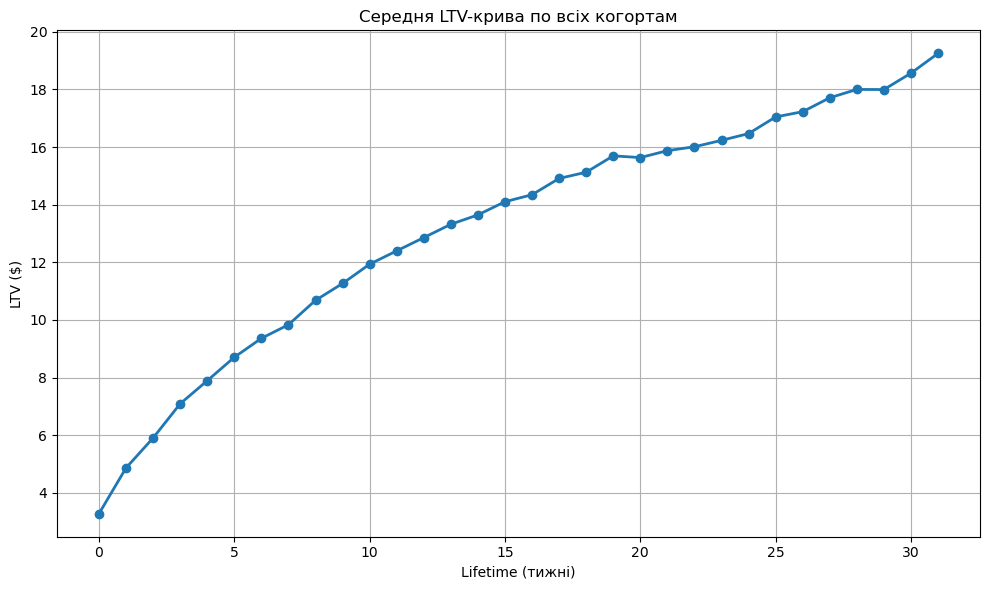

In [20]:
display(Markdown("# Графік середньої LTV-кривої"))

plt.figure(figsize=(10, 6))

plt.plot(
    avg_ltv_curve["lifetime_weeks"],
    avg_ltv_curve["avg_ltv"],
    marker="o",
    linewidth=2
)

plt.title("Середня LTV-крива по всіх когортам")
plt.xlabel("Lifetime (тижні)")
plt.ylabel("LTV ($)")

plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
display(Markdown(""" 
Графік демонструє, що основна частина приросту LTV формується у перші **4–6 тижнів** після першої покупки, що робить цей період критичним для утримання користувачів. 

Подальше плавне зростання LTV свідчить про стабільний long-term сегмент користувачів, який забезпечує довгострокову монетизацію продукту та формує значну частину загального доходу.
"""))

 
Графік демонструє, що основна частина приросту LTV формується у перші **4–6 тижнів** після першої покупки, що робить цей період критичним для утримання користувачів. 

Подальше плавне зростання LTV свідчить про стабільний long-term сегмент користувачів, який забезпечує довгострокову монетизацію продукту та формує значну частину загального доходу.


In [22]:
display(Markdown("# Підготовка даних для прогнозу LTV"))

# Використовуємо перші 20 тижнів для навчання (стабільний сегмент)
train_max_week = 20

train_data = avg_ltv_curve[avg_ltv_curve["lifetime_weeks"] <= train_max_week]

X_train = train_data[["lifetime_weeks"]]
y_train = train_data["avg_ltv"]

display(train_data.tail())

# Підготовка даних для прогнозу LTV

,lifetime_weeks,avg_ltv,cohorts_cnt
16,16,14.345054,17
17,17,14.910639,16
18,18,15.124784,15
19,19,15.694101,14
20,20,15.633432,13


In [23]:
display(Markdown("# Навчання моделі прогнозу LTV (Linear Regression)"))

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

display(Markdown(f"Коефіцієнт (slope): **{model.coef_[0]:.4f}**"))
display(Markdown(f"Intercept: **{model.intercept_:.4f}**"))

# Навчання моделі прогнозу LTV (Linear Regression)

Коефіцієнт (slope): **0.5821**

Intercept: **5.2666**

In [24]:
display(Markdown("# Прогноз LTV на 52 тижні"))

# future timeline
future_weeks = pd.DataFrame({
    "lifetime_weeks": range(0, 53)
})

# prediction
future_weeks["predicted_ltv"] = model.predict(future_weeks)

display(future_weeks.tail())

# Прогноз LTV на 52 тижні

,lifetime_weeks,predicted_ltv
48,48,33.209671
49,49,33.791818
50,50,34.373965
51,51,34.956112
52,52,35.538260


# Фактичний vs Прогнозований LTV

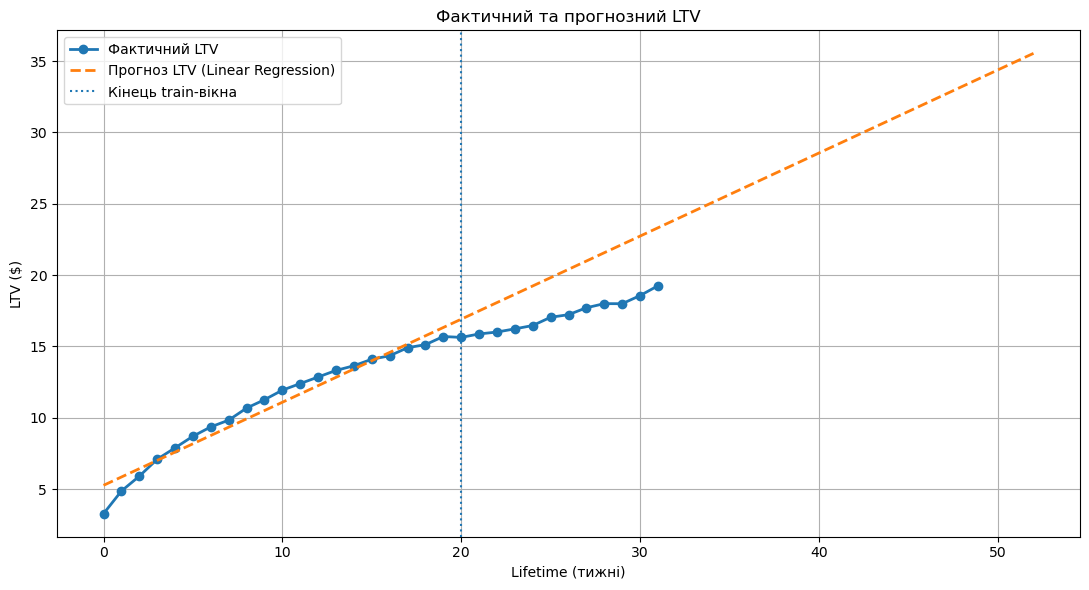

In [25]:
display(Markdown("# Фактичний vs Прогнозований LTV"))

plt.figure(figsize=(11, 6))

# Actual
plt.plot(
    avg_ltv_curve["lifetime_weeks"],
    avg_ltv_curve["avg_ltv"],
    marker="o",
    linewidth=2,
    label="Фактичний LTV"
)

# Predicted
plt.plot(
    future_weeks["lifetime_weeks"],
    future_weeks["predicted_ltv"],
    linestyle="--",
    linewidth=2,
    label="Прогноз LTV (Linear Regression)"
)

plt.axvline(
    x=train_max_week,
    linestyle=":",
    label="Кінець train-вікна"
)

plt.title("Фактичний та прогнозний LTV")
plt.xlabel("Lifetime (тижні)")
plt.ylabel("LTV ($)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
display(Markdown("""

Прогнозований річний **LTV (52 тижні)** становить приблизно **\\$35.5 на одного користувача**, що відповідає в середньому **~14 активним тижням підписки** при ціні **\\$2.49 за тиждень**.

Це свідчить про наявність стабільного long-tail ефекту монетизації, коли значна частина доходу формується за рахунок користувачів із тривалішим життєвим циклом.
"""))



Прогнозований річний **LTV (52 тижні)** становить приблизно **\$35.5 на одного користувача**, що відповідає в середньому **~14 активним тижням підписки** при ціні **\$2.49 за тиждень**.

Це свідчить про наявність стабільного long-tail ефекту монетизації, коли значна частина доходу формується за рахунок користувачів із тривалішим життєвим циклом.


In [27]:
display(Markdown("""
# Висновки та бізнес-інсайти

- Середній прогнозований **річний LTV (52 тижні)** становить приблизно **\\$35.5 на користувача**, що відповідає близько **14 активним тижням підписки** при вартості **\\$2.49/тиждень**.
- Найбільший приріст LTV відбувається у перші **4–6 тижнів** після першої покупки, що вказує на критичну важливість early-retention.
- Після ~12 тижнів крива LTV переходить у фазу повільного зростання, що свідчить про стабільний long-tail ефект монетизації.
- Модель лінійної регресії демонструє хорошу узгодженість із фактичними даними у train-вікні (0–20 тижнів) та дозволяє коректно екстраполювати тренд.

---

## Ключові продуктові інсайти

- Більшість користувачів припиняють підписку у перші тижні використання продукту, тому саме onboarding та early engagement мають найбільший вплив на загальний LTV.
- Наявність довгострокових користувачів формує значну частку загального доходу, що робить retention-стратегії критично важливими.
- Навіть невелике покращення retention на 1–2 тижні може мати суттєвий вплив на сумарний LTV.

---

## Обмеження моделі

- Використана модель лінійної регресії не враховує ефект насичення (saturation), тому може дещо переоцінювати LTV на довгостроковому горизонті.
- Прогноз базується на середній LTV-кривій без сегментації користувачів (наприклад, за країнами, каналами залучення або типами продуктів).
- Дані охоплюють обмежений часовий період, що може впливати на стабільність long-term прогнозу.

---

## Рекомендації для бізнесу

- Інвестувати у покращення retention протягом перших 2–4 тижнів (покращення onboarding, персоналізовані пуш-нотифікації, trial-to-paid оптимізація).
- Запровадити сегментований LTV-аналіз (за країнами, маркетинговими каналами, типами користувачів).
- Використовувати більш гнучкі моделі прогнозування (logarithmic curve, survival analysis, BG/NBD + Gamma-Gamma) для підвищення точності long-term LTV.
- Регулярно оновлювати LTV-модель на нових когортних даних для підтримки актуальності прогнозу.

"""))



# Висновки та бізнес-інсайти

- Середній прогнозований **річний LTV (52 тижні)** становить приблизно **\$35.5 на користувача**, що відповідає близько **14 активним тижням підписки** при вартості **\$2.49/тиждень**.
- Найбільший приріст LTV відбувається у перші **4–6 тижнів** після першої покупки, що вказує на критичну важливість early-retention.
- Після ~12 тижнів крива LTV переходить у фазу повільного зростання, що свідчить про стабільний long-tail ефект монетизації.
- Модель лінійної регресії демонструє хорошу узгодженість із фактичними даними у train-вікні (0–20 тижнів) та дозволяє коректно екстраполювати тренд.

---

## Ключові продуктові інсайти

- Більшість користувачів припиняють підписку у перші тижні використання продукту, тому саме onboarding та early engagement мають найбільший вплив на загальний LTV.
- Наявність довгострокових користувачів формує значну частку загального доходу, що робить retention-стратегії критично важливими.
- Навіть невелике покращення retention на 1–2 тижні може мати суттєвий вплив на сумарний LTV.

---

## Обмеження моделі

- Використана модель лінійної регресії не враховує ефект насичення (saturation), тому може дещо переоцінювати LTV на довгостроковому горизонті.
- Прогноз базується на середній LTV-кривій без сегментації користувачів (наприклад, за країнами, каналами залучення або типами продуктів).
- Дані охоплюють обмежений часовий період, що може впливати на стабільність long-term прогнозу.

---

## Рекомендації для бізнесу

- Інвестувати у покращення retention протягом перших 2–4 тижнів (покращення onboarding, персоналізовані пуш-нотифікації, trial-to-paid оптимізація).
- Запровадити сегментований LTV-аналіз (за країнами, маркетинговими каналами, типами користувачів).
- Використовувати більш гнучкі моделі прогнозування (logarithmic curve, survival analysis, BG/NBD + Gamma-Gamma) для підвищення точності long-term LTV.
- Регулярно оновлювати LTV-модель на нових когортних даних для підтримки актуальності прогнозу.

